# Machine learning model to predict chl-a concentration in the sabah coast of Malaysia, Kota Kinabalu (LSTM model) (2013 to 2020 data)

In [1]:
# give access to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing the library needed

from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler



In [3]:
# read the data 
df = pd.read_csv("/content/drive/MyDrive/Ocean_Hackathon/chla_by_sites.csv")
df

,time,lat_site_1,lon_site_1,CHL_1,lat_site_2,lon_site_2,CHL_2,lat_site_3,lon_site_3,CHL_3,lat_site_4,lon_site_4,CHL_4
0,2013-01-01,6.104164,116.10417,0.564678,6.062498,116.10417,0.560019,6.020831,116.10417,0.510485,6.020831,116.06251,0.477669
1,2013-01-02,6.104164,116.10417,0.564721,6.062498,116.10417,0.560072,6.020831,116.10417,0.510547,6.020831,116.06251,0.477821
2,2013-01-03,6.104164,116.10417,0.587605,6.062498,116.10417,0.548594,6.020831,116.10417,0.471003,6.020831,116.06251,0.469086
3,2013-01-04,6.104164,116.10417,0.442397,6.062498,116.10417,0.448292,6.020831,116.10417,0.431459,6.020831,116.06251,0.405297
4,2013-01-05,6.104164,116.10417,0.327515,6.062498,116.10417,0.350212,6.020831,116.10417,0.348730,6.020831,116.06251,0.345481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2020-12-27,6.104164,116.10417,3.216164,6.062498,116.10417,4.875177,6.020831,116.10417,7.636661,6.020831,116.06251,5.718042
2918,2020-12-28,6.104164,116.10417,3.149262,6.062498,116.10417,4.772104,6.020831,116.10417,7.474741,6.020831,116.06251,5.580632
2919,2020-12-29,6.104164,116.10417,2.152458,6.062498,116.10417,2.856548,6.020831,116.10417,4.321699,6.020831,116.06251,3.686310
2920,2020-12-30,6.104164,116.10417,1.799753,6.062498,116.10417,1.991847,6.020831,116.10417,2.006027,6.020831,116.06251,1.931194


In [4]:
# choose only one site for machine learning model 
site1 = df.drop(['lat_site_1','lon_site_1','lat_site_2','lon_site_2','lat_site_3','lon_site_3','lat_site_4','lon_site_4','CHL_2','CHL_3','CHL_4'],axis=1)

In [5]:
site1

,time,CHL_1
0,2013-01-01,0.564678
1,2013-01-02,0.564721
2,2013-01-03,0.587605
3,2013-01-04,0.442397
4,2013-01-05,0.327515
...,...,...
2917,2020-12-27,3.216164
2918,2020-12-28,3.149262
2919,2020-12-29,2.152458
2920,2020-12-30,1.799753


In [6]:
site1 = site1.set_index('time')

In [7]:
# choose data from 2018-01-01 onwards for training 
# df = df[df['date']>"2017-12-31"].set_index('date')

In [8]:
factor = site1.CHL_1.max()
factor

26.775383

In [9]:
# normalise chl data, sst and par
site1['CHL_1']=site1['CHL_1']/factor
#df['analysed_sst']=df['analysed_sst']/df.analysed_sst.max()
#df['PAR_mean']=df['PAR_mean']/df.PAR_mean.max()

In [10]:
site1.to_numpy()


array([[0.02108944],
       [0.02109106],
       [0.02194572],
       ...,
       [0.08038944],
       [0.06721672],
       [0.06733175]])

In [11]:
# from the dataset, we then now extract the neccessary data into the input and output
# since we plan to use a LSTM model to learn the time-series pattern, we decide to use a window size of 7
# hence, we define a function to achieve that

def get_X_Y(df,window=6):
    df_numpy = df.to_numpy()
    x = []
    y = []
    
    for i in range(len(df_numpy)-window):
        row = df_numpy[i:i+window]
        x.append(row)
        
        label = df_numpy[i+window]
        y.append(label)
        
    return np.array(x),np.array(y)

In [12]:
x,y = get_X_Y(site1)

In [13]:
# examine the shape of input and output
x.shape, y.shape

((2916, 6, 1), (2916, 1))

In [14]:
# reshaping the y data input shape
y = y.reshape(2916)

In [15]:
2916*10/100

291.6

In [16]:
x_train,y_train = x[0:2332], y[0:2332]  #2013-2018. #80%
x_val,y_val=x[2332:2623], y[2332:2623]  # 2019.    #10%
x_test,y_test=x[2623:2915], y[2623:2915] # 2020     #10%

In [17]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((2332, 6, 1), (2332,), (291, 6, 1), (291,), (292, 6, 1), (292,))

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
opt1 = Adam(learning_rate=0.01)

In [21]:
# building the model

model = Sequential()
#model.add(MaxPool1D(pool_size=2,input_shape=(6,3)))
#model.add(Conv1D(filters=64, kernel_size=3,input_shape=(6,3),activation='relu'))
#model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh',return_sequences=True,input_shape=(6,1))) #return_sequence = False
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
#model.add(LSTM(64, activation='tanh'))
#model.add(Dense(60,activation='relu',input_shape=(6,1)))
model.add(Dropout(0.2))
#model.add(Dense(32,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 64)             16896     
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                990       
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 30,333
Trainable params: 30,333
Non-trai

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_error'])

In [23]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),verbose=1,epochs=30,batch_size=6)

Epoch 1/30
389/389 [==============================] - 6s 7ms/step - loss: 0.0174 - mean_absolute_error: 0.0550 - val_loss: 7.3764e-04 - val_mean_absolute_error: 0.0150
Epoch 2/30
389/389 [==============================] - 3s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0188 - val_loss: 6.6131e-04 - val_mean_absolute_error: 0.0159
Epoch 3/30
389/389 [==============================] - 3s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0191 - val_loss: 6.7070e-04 - val_mean_absolute_error: 0.0153
Epoch 4/30
389/389 [==============================] - 2s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0188 - val_loss: 6.3919e-04 - val_mean_absolute_error: 0.0160
Epoch 5/30
389/389 [==============================] - 3s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0188 - val_loss: 6.1780e-04 - val_mean_absolute_error: 0.0177
Epoch 6/30
389/389 [==============================] - 2s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0188 - val_loss: 8.2543e-04 - val_mean_absolute_error:

In [37]:
b = model.predict(x_test)

10/10 [==============================] - 1s 2ms/step


In [38]:
train_result=pd.DataFrame({'predicted':b.flatten(),'actual':y_test.flatten()})
train_result

,predicted,actual
0,0.015188,0.021591
1,0.016265,0.024580
2,0.017695,0.082748
3,0.036800,0.044850
4,0.041038,0.053852
...,...,...
287,0.044804,0.049007
288,0.044596,0.120116
289,0.078559,0.117618
290,0.102550,0.080389


In [39]:
factor

26.775383

In [40]:
# factor back the original concentration of chlorophyll a
train_result['predicted']=train_result['predicted']*factor
train_result['actual']=train_result['actual']*factor
train_result

,predicted,actual
0,0.406661,0.578099
1,0.435510,0.658127
2,0.473784,2.215607
3,0.985343,1.200867
4,1.098821,1.441913
...,...,...
287,1.199645,1.312185
288,1.194082,3.216164
289,2.103434,3.149262
290,2.745803,2.152458


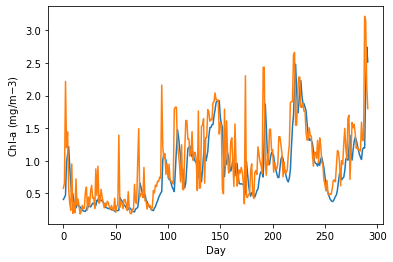

In [41]:
plt.plot(train_result.index,train_result.predicted)
plt.plot(train_result.index,train_result.actual)
plt.xlabel('Day')
plt.ylabel('Chl-a (mg/m$-3$)')
plt.savefig('/content/drive/MyDrive/Ocean_Hackathon/well_trainned.jpg')

In [42]:
import scipy.stats as sts 

In [43]:
r,p=sts.pearsonr(train_result['predicted'],train_result['actual'])

In [44]:
# test the r value of predicted and actual data
r

0.7204846347235597

# Using other data with different time range to test the built model (November to December 2022 data)

In [45]:
# saving the model for future prediciting purpose 
model.save('/content/drive/MyDrive/Ocean_Hackathon/prediciting_model.h5')

In [46]:
# load the saved model into memomry 
model = load_model("/content/drive/MyDrive/Ocean_Hackathon/for dashboard/prediciting_model.h5")

In [47]:
# import data for forecasting purpose
data_forcasting = pd.read_csv('/content/drive/MyDrive/Ocean_Hackathon/forcasting.csv')

In [48]:
data_forcasting = data_forcasting.drop('analysed_sst',axis=1).set_index('time')

In [49]:
# the scale factor used in the model, going to apply in the predicting data 
factor

26.775383

In [50]:
# scale the data
data_forcasting['CHL']=data_forcasting['CHL']/factor

In [51]:
# divide the data into test and actual set 
x1,y1=get_X_Y(data_forcasting)

In [52]:
# check the shape of the data, which have to fit in the size of model which have trained 
x1.shape,y1.shape

((18, 6, 1), (18, 1))

In [53]:
# predicting the future value 
c = model.predict(x1)

1/1 [==============================] - 1s 636ms/step


In [54]:
# compared the predicting with actual 
train_result_train=pd.DataFrame({'predicted':c.flatten(),'actual':y1.flatten()})
train_result_train

,predicted,actual
0,0.065869,0.063976
1,0.064725,0.053291
2,0.057675,0.054186
3,0.053987,0.041092
4,0.046885,0.074132
5,0.056235,0.074132
6,0.064084,0.084355
7,0.073686,0.106714
8,0.090900,0.106791
9,0.101132,0.106666


In [55]:
# get the r value 
r1,p1=sts.pearsonr(train_result_train['predicted'],train_result_train['actual'])

In [56]:
r1

0.5924138350607606

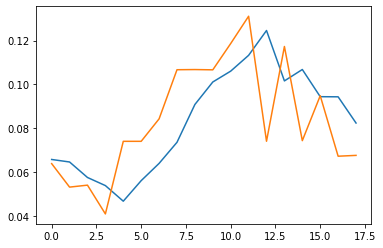

In [57]:
# visualise predicting value 
plt.plot(train_result_train.index,train_result_train.predicted)
plt.plot(train_result_train.index,train_result_train.actual)